# Gatos vs. Perros

En este problema hay solo dos clases: gatos y perros. El ejemplo presenta dos bases de datos y es necesario escoger uno de ellos:.


* Reduced dataset: con algunas imágenes de gatos y perros para realizar un entrenamiento más rápido (pero menos efectivo). Para este conjunto se recomienda una CNN simple (de pocas capas, ver modelo para "reduced dataset").

* Full dataset: con un conjunto mayor de imágenes de gatos y perros que se usa para entrenar un modelo más efectivo (con mejor accuracy) pero con un entrenamiento más lento. Para este conjunto se recomienda una CNN compleja (de más capas, ver modelo para "large dataset").

Interesante en este ejemplo es que los conjuntos de datos de training y testing están pre-definidos y no se escogen de manera aleatoria. Sin embargo, el conjunto de validación es escogido aleatoriamente del conjunto de training. Esta información es definida con la función `ImageLoader`.

Referencia: [CNN Model With PyTorch For Image Classification](https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48), by Pranjal Soni (Medium)

In [ ]:
# Reduced dataset
!wget https://www.dropbox.com/s/kugbkmznlyb4krv/catdog_reduced.zip?dl=0
!unzip -qq catdog_reduced.zip

In [ ]:
# Full dataset
!wget https://www.dropbox.com/s/rk2vrsow7yk7651/test_set.zip?dl=0
!wget https://www.dropbox.com/s/6sgiquis94t1r9t/training_set.zip?dl=0

!unzip -qq test_set.zip 
!unzip -qq training_set.zip 

In [16]:
import torch
import torchvision
from   torchvision import transforms
from   torchvision.datasets import ImageFolder
from   torch.utils.data.dataloader import DataLoader
from   torch.utils.data import random_split
from   sklearn.metrics import confusion_matrix, accuracy_score

#train and test data directory
#full dataset
#train_dir = "training_set/"
#test_dir  = "test_set/"
#reduced dataset
train_dir = "catdog/train/"
test_dir  = "catdog/test/"

#load the train and test data
train_set = ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),transforms.RandomHorizontalFlip(),transforms.ToTensor()]))

test_set = ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((64,64)),transforms.ToTensor()]))

img,_ = train_set[0]
print('Size image: '+ str(img.shape))
print('   Classes: ',train_set.classes)

Size image: torch.Size([3, 64, 64])
   Classes:  ['cats', 'dogs']


In [17]:
!wget https://www.dropbox.com/s/caz30t81td7zxgl/cnn_utils.py?dl=0
from cnn_utils import *
print('cnn_utils module has been loaded')

cnn_utils module has been loaded


"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Image: 5, Label : cats


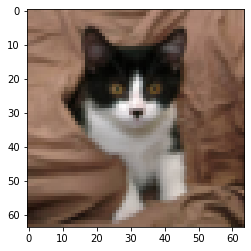

In [18]:
#display an image in the training dataset
display_img(train_set,5)

In [19]:
#load the train and validation into batches.

batch_size = 100 
val_size   = 800 
train_size = len(train_set) - val_size 

train_data,val_data = random_split(train_set,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 2, pin_memory = True)


Length of Train Data : 3200
Length of Validation Data : 800


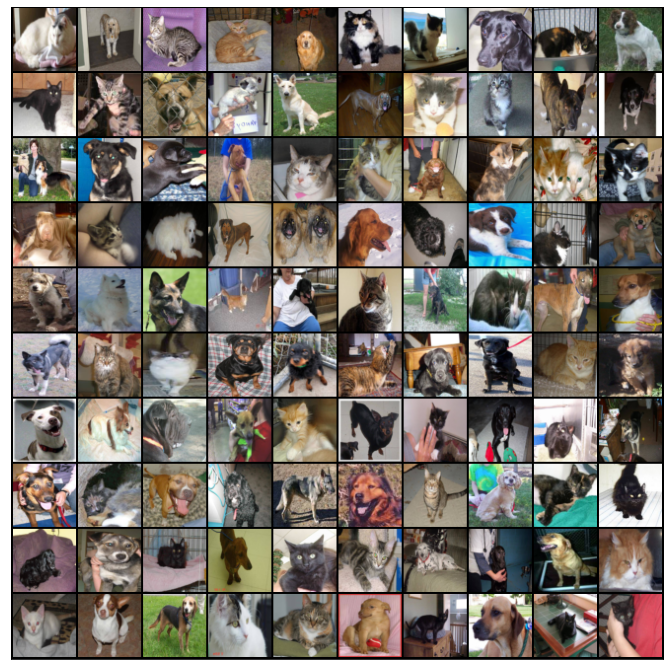

In [20]:
show_batch(train_dl,nrow=10)

In [21]:
# for reduced dataset
class CNN_Classification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 4, kernel_size = 5, stride = 1, padding = 0),
            nn.ReLU(),
            nn.Conv2d(4,8, kernel_size = 5, stride = 4, padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(2,2),            

            nn.Flatten(),
            nn.Linear(392,32),
            nn.Linear(32,2)
        )
    
    def forward(self, xb):
        return self.network(xb)


In [22]:
# for full dataset
class CNN_Classification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(8,16, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),            

            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),            

            nn.Flatten(),
            nn.Linear(2048,1024),
            nn.Linear(1024,128),
            nn.Linear(128,2),
            nn.Dropout(0.25)
        )
    
    def forward(self, xb):
        return self.network(xb)


In [23]:
model =  CNN_Classification()
print(model)

CNN_Classification(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=2048, out_features=1024, bias=True)
    (12): Linear(in_features=1024, out_features=128, bias=True)
    (13): Linear(in_features=128, out_features=2, bias=True)
    (14): Dropout(p=0.25, inplace=False)
  )
)


In [24]:
#fitting the model on training data and record the result after each epoch
num_epochs = 50
opt_func   = torch.optim.Adam
lr         = 0.0005
history    = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch    Train-Loss   Val-Loss    Val-Acc   Best    Time [sec]
------------------------------------------------------------------
    0      0.6966      0.6941      0.4900    ***      16.3 
    1      0.6926      0.6934      0.4900             15.1 
    2      0.6934      0.6919      0.5312    ***      15.7 
    3      0.6911      0.6873      0.5438    ***      15.6 
    4      0.6869      0.6852      0.5163             15.8 
    5      0.6689      0.6785      0.5537    ***      17.3 
    6      0.6493      0.6428      0.6350    ***      18.1 
    7      0.6368      0.6022      0.6788    ***      16.6 
    8      0.6203      0.5915      0.7075    ***      16.2 
    9      0.6033      0.5766      0.7100    ***      17.3 
   10      0.5891      0.5799      0.7013             17.1 
   11      0.5764      0.5680      0.7000             16.2 
   12      0.5654      0.5837      0.6875             18.4 
   13      0.5734      0.5597      0.7288    ***      17.2 
   14      0.5468      0.5570 

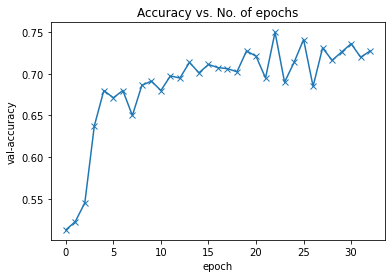

In [11]:
plot_accuracies(history)

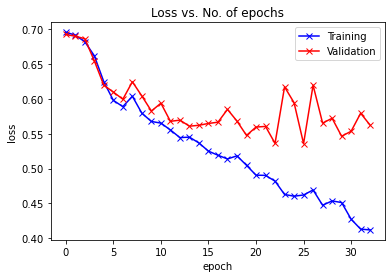

In [12]:
plot_losses(history)

In [13]:
model = load_model(CNN_Classification,'best_model.pt')

best_model.pt loaded.


In [14]:
ytest = get_labels(model,test_set)
ypred = get_prediction(model,test_set)

acc   = accuracy_score(ytest,ypred) 
C     = confusion_matrix(ytest,ypred)

print('Performance on Testing subset:')
print('Accuracy:')
print(acc)
print(' ')
print('Confusion Matrix = ')
print(C)

Performance on Testing subset:
Accuracy:
0.7262737262737263
 
Confusion Matrix = 
[[361 140]
 [134 366]]


In [15]:
C1,acc1 = performance(model,train_data,'Training')
C2,acc2 = performance(model,val_data,'Validation')
C3,acc3 = performance(model,test_set,'Testing')

Training Confusion Matrix = 
[[1315  275]
 [ 337 1273]]
 
Training Accuracy = 0.8087
 
Validation Confusion Matrix = 
[[308 102]
 [105 285]]
 
Validation Accuracy = 0.7412
 
Testing Confusion Matrix = 
[[361 140]
 [134 366]]
 
Testing Accuracy = 0.7263
 
